# ___
# [ Geoinformatika ]

## Strojové učení


**Katedra aplikované geoinformatiky a kartografie**, Přírodovědecká fakulta, Univerzita Karlova
Albertov 6, 128 43 Praha 2

*Lukáš Brodský lukas.brodsky@natur.cuni.cz*

### Rozhodovací strom *(Decision tree)* v Pythonu 


Tento Jupyter notbooku demonstruje strojové učení s využitím algoritmu rozhodovací strom z knihovny Scikit learn (*https://scikit-learn.org*). 


### Řešený problem
Klasifikace druhů kosatců na základě jejich vlastností (délka a šířka okvětních a kališních lístků).  

### Měření míry úspěchu

Strojové učení používá podobné metriky jako DPZ. Pojmenování se trochu liší. 

Specificita (*precision*) obecně říká, kolik vzorků označených za pozitivních je opravdu pozitivních.

$$ precision = \frac{TP}{TP+FP} $$

TP označuje počet správně označených pozitivních vzorků (*true positives*)
FP označuje počet falešně pozitivních vzorků (*false negatives*)

Senzitivita (*recall*) testu obecně vyjadřuje kolik pozitivních vzorků bylo podchyceno klasifikátorem (klasifikováno jako pozitivní).


$$ recall = \frac{TP}{TP+FN} $$

FN je počet falešně negativních vzorků (*false negatives*)


Zda je pro nás důležitější *precision* nebo *recall*, záleží na konkrétní úloze. Někdy vadí více falešně pozitivní případy (např. příliš mnoho relevantních mailů označených za spam), jindy bude více vadit nezachycený pozitivní případ (např. neodhalený výskyt nemoci).

Další často používanou metrikou je tzv. **F1 skóre**. Kombinuje *precision* a *recall*, a to tak, že obě tyto metriky mají stejnou váhu (přizpívají stejnou měrou k výsledku). Čím větší hodnota, tím lepší výsledek. Maximální hodnota je jedna, minimální 0.

$$ F1 = 2 \frac{precision \cdot recall}{precision + recall}$$



S použitím F1-skóre balancujeme *precision* a *recall* (harmonický průměr). Tuto metriku vybereme pro hodnocení úspěšnosti našeho modelu pro tento problem!  


In [1]:
# Knihovny

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Jupyter notebook vizualizace
%matplotlib inline
import seaborn as sns

# kodovani 
from sklearn.preprocessing import LabelEncoder
# rozdeleni na trenovaci a testovaci dataset 
from sklearn.model_selection import train_test_split
# trida klasifikatoru rozhodovaci strom 
from sklearn.tree import DecisionTreeClassifier
# validacni indikatory a procedury 
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
# vizualizace stromu 
from sklearn.tree import plot_tree
from matplotlib.pyplot import figure

### Nacteni vstupnich dat

In [2]:
# vstupni data
df = sns.load_dataset('iris') 
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


### Explorace vstupnich dat 

In [3]:
# zakladni info 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


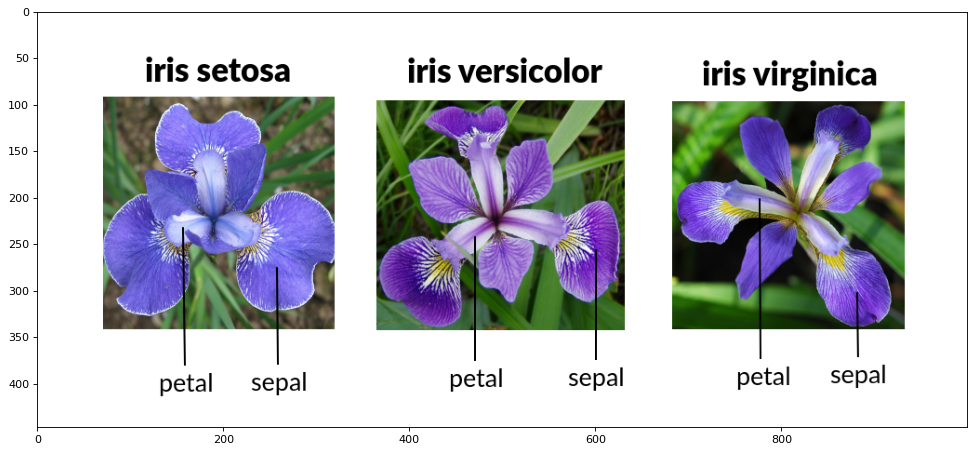

In [4]:
import matplotlib.image as mpimg

img = 'iris-dataset.png'
img = mpimg.imread('iris-dataset.png')
plt.figure(figsize=(15, 10), dpi=80)
plt.imshow(img)
# okvětní lístek a kališní lístek 

In [5]:
# dimenzionalita matice 
df.shape

(150, 5)

In [6]:
# chybejici atributy? 
df.isnull().any()

sepal_length    False
sepal_width     False
petal_length    False
petal_width     False
species         False
dtype: bool

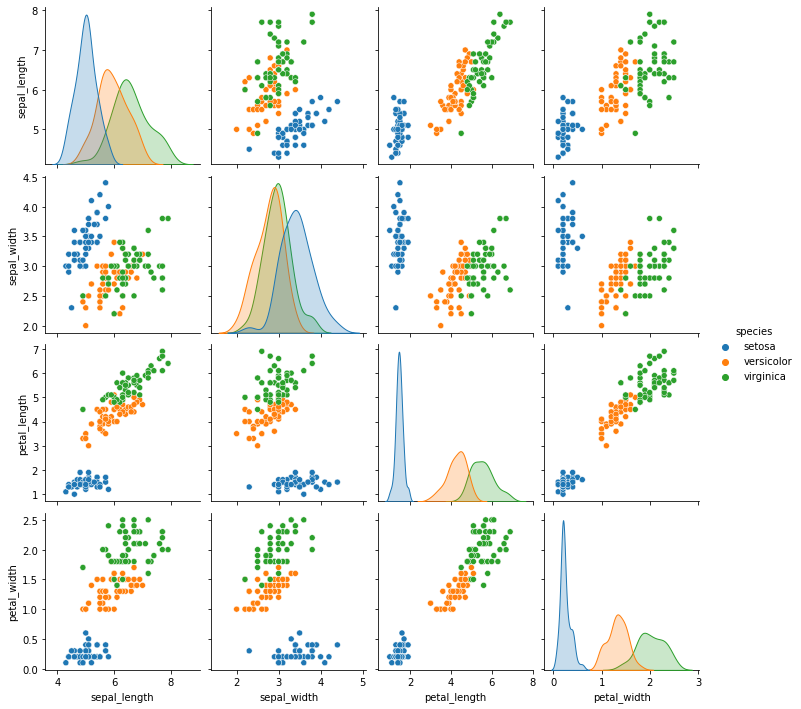

In [7]:
# vizualizace atributu - pruzkumova analyza 
sns.pairplot(data=df, hue = 'species')

In [26]:
# existuji korelace (linerani zavislosti) v matici priznaku?
# sns.heatmap(df.corr(), cmap="Greens")

## Priprava dat

In [8]:
df.columns

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width',
       'species'],
      dtype='object')

In [9]:
# klasifikacni tridy 
df['species']

0         setosa
1         setosa
2         setosa
3         setosa
4         setosa
         ...    
145    virginica
146    virginica
147    virginica
148    virginica
149    virginica
Name: species, Length: 150, dtype: object

In [10]:
cilove_tridy = df['species']
df1 = df.copy()
df1 = df1.drop('species', axis = 1)

In [11]:
# Defining the attributes 
X = df1

In [12]:
X

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [75]:
# cilove_tridy

In [13]:
# kodovani trid 
le = LabelEncoder()
cilove_tridy = le.fit_transform(cilove_tridy) 
cilove_tridy

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [14]:
# kodovani 
spec_kod  = pd.concat([df['species'], pd.DataFrame(cilove_tridy)], axis=1)

for col in spec_kod:
    print(spec_kod[col].unique())

['setosa' 'versicolor' 'virginica']
[0 1 2]


In [15]:
y = cilove_tridy

### Rozdeleni na trenovaci a testovaci dataset 

In [16]:
# nahodne rozdeleni 
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size = 0.9, random_state = 100)

print("Trenovaci mnozina ", X_train.shape)
print("Testovaci mnozina ", X_test.shape)

# zmen podil testovacich mnozin (pripadne zmen rozdeleni na stratifikovane) 

Trenovaci mnozina  (15, 4)
Testovaci mnozina  (135, 4)


### Modelovani a testovani stromu

In [17]:
# instance treidy pro rozhodovaci strom 
# hyperparametry: max. depth, min. samples, splitter
strom = DecisionTreeClassifier(max_depth=5, min_samples_split=3, splitter='random') 

# krizova validace 
cv_tree = cross_val_score(strom, X_train,y_train, cv=3, scoring='f1_weighted')
print('Krizova validace!')

Krizova validace!


In [18]:
print('Prumer vazeneho F1-skore: {:.3f}'.format(np.mean(cv_tree)))

Prumer vazeneho F1-skore: 0.907


Sklearn f1_score: 
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score

    
'micro':

    Calculate metrics globally by counting the total true positives, false negatives and false positives.
'macro':

    Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

'weighted':

    Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.


In [19]:
# "fitovani" modelu na data 
strom.fit(X_train,y_train)
print('Rozhodovaci strom je vytvoren!')

Rozhodovaci strom je vytvoren!


In [20]:
# Validace: predikce na testovacim data setu 

y_pred = strom.predict(X_test)
print("Klasifikacni report \n", classification_report(y_test,y_pred)) 

Klasifikacni report 
               precision    recall  f1-score   support

           0       1.00      0.80      0.89        46
           1       0.56      0.70      0.62        43
           2       0.70      0.67      0.69        46

    accuracy                           0.73       135
   macro avg       0.75      0.73      0.73       135
weighted avg       0.76      0.73      0.74       135



In [207]:
# f1_score(y_test, y_pred, average='weighted')

Text(0.5, 1.0, 'F1-score: 0.736')

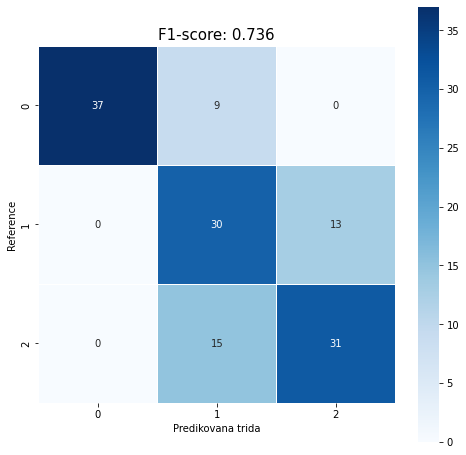

In [21]:
# konfuzni matice 
cm = confusion_matrix(y_test, y_pred) 
plt.figure(figsize=(8,8))
sns.heatmap(data=cm,linewidths=.5, annot=True, square = True, cmap = 'Blues')
plt.ylabel('Reference')
plt.xlabel('Predikovana trida')
all_sample_title = 'F1-score: {0}'.format(round(f1_score(y_test, y_pred, average='weighted'), 3))
plt.title(all_sample_title, size = 15)

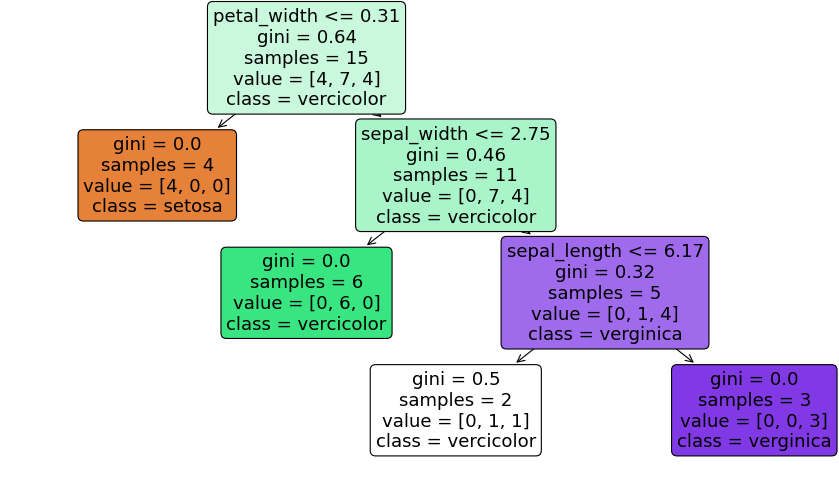

In [33]:
# Visualizace stromu 
figure(figsize=(13, 7), dpi=80)
rozhodovaci_strom = plot_tree(decision_tree=strom, feature_names = df1.columns,
class_names =["setosa", "vercicolor", "verginica"] , filled=True ,  precision=2, rounded=True)

In [27]:
# zkuste najit vhodny pomer trenovacich a testovacich mnozin 
# napr. 
cv_f1 = []
test_f1 = [] 
for ts in range(10, 100, 10):
    print('Podil testovaci mnoziny je {} %'.format(ts))
    podil = ts / 100 
    # 1. rodeleni mnoziny
    # X_train, X_test, y_train, y_test = train_test_split(X , y, test_size = podil, random_state = 100)
    
    # 2. krizova validace 
    # uloz F1-skore do cv_f1 
    
    # 3. parametrizuj strom 
    
    # 4. over model na testovaci mnozine 
    # uloz F1-skore do test_f1

# zobraz graf zavislosti cv_f1 a test_f1 na velikosti (podilu) trenovaci mnoziny 
# jak velky potrebujeme trenovaci mnozinu aby model nebyl preucen v tomto konkretnim pripade 

Podil testovaci mnoziny je 10 %
Podil testovaci mnoziny je 20 %
Podil testovaci mnoziny je 30 %
Podil testovaci mnoziny je 40 %
Podil testovaci mnoziny je 50 %
Podil testovaci mnoziny je 60 %
Podil testovaci mnoziny je 70 %
Podil testovaci mnoziny je 80 %
Podil testovaci mnoziny je 90 %


In [ ]:
# doplnujici uloha - uprav hyperparametry stromu, najdi optimalni 